In [26]:
# basically this means `import note_evaluation_helper`
%run 'note_evaluation_helper.ipynb'

[]


In [ ]:
def cqt_function(signal_to_ayse):
    '''
    Compute the cqt response over a set of notes.

    Parameters
    ----------
    signal_to_ayse : input array, real
                     4096 entries long

    Output
    ----------
    MIDI numbers
    60 is middle C, which is C4
    
    Todo
    ----
    We should not be generating the kernels every time.
    Actually we could simply multiply with the FFT of the signal.
    So:
    Make it customisable to a random starting note.
    Outsource the precomputation to a function instead - do something like load kernels.
    Do both of these at the same time.
    (but anyway we just want an accurate demo, computation time doesn't seem to be a problem here)
    '''

    length = len(signal_to_ayse)
#     print(length)

    # fast fourier transform
    freq_domain = np.fft.fft(signal_to_ayse)
    
    # defining the 36 notes bins
    bins = 40
    freq_ref_notes = [261.625565 * (2. ** (n / 36. - 5. / 72.)) for n in range(bins)]

    # defining the time kernel
    # different note have different "kernels"
    bell_curves = []
    for note in range(len(freq_ref_notes)):
        # I don't think this is defined properly?
        bell_curve = np.exp(-((np.arange(-1., 1., 2. / length)) * (2. ** (note / 36.))) ** 2.)
        bell_curves.append(bell_curve)

    # multiplying the waveform with the window
    kernels = []
    for note in range(bins):
        # generate cosine/sine wave
        wave = np.exp((np.arange(length) - length / 2.) * -1.j * 2. * np.pi * freq_ref_notes[note] / 44100.)
        # multiplying a window over it
        kernels.append(np.multiply(wave, bell_curves[note]))

    # taking fourier transform for the frequency kernel
    fft_kernels = []
    for note in range(bins):
        fft_kernels.append(np.fft.fft(kernels[note]))
    # all of the above should be run only once
    # but the maximum complexity is only the FFT, it is still not a problem
    # the focus is an MVP anyway
    # we prioritse accuracy here though
    # creating arrays to populate for each one-third-semitone
    cqt_resp_specs = []
    cqt_resp = []

    # populating the arrays
    for note in range(bins):
        cqt_resp_spec = []
        for entry in range(length):
            cqt_resp_spec.append(fft_kernels[note][entry] * freq_domain[entry])
        cqt_resp_specs.append(cqt_resp_spec)
        cqt_resp.append(sum([abs(x) for x in cqt_resp_spec]))

    # finding peaks in the cqt response
    notesrum = cqt_resp  # remove redundant variable please

    #     plt.figure(figsize=(16,2))
    #     plt.plot(np.linspace(0, 70*44100/4096, num=70, endpoint=False),
    #              np.absolute(freq_domain[:70])/np.max(np.absolute(freq_domain[:70])))
    #     plt.plot(np.geomspace(261.625565*2**(-3/36), 261.625565*2**(37/36), num=40, endpoint=False),
    #              np.absolute(cqt_resp)/np.max(np.absolute(cqt_resp)))
    #     plt.show()

    notesrum_peak_only = [0.0] * len(notesrum)
    notesrum_sum = sum(notesrum)

    for index in range(bins - 1)[1:]:
        if notesrum[index - 1] < notesrum[index] and notesrum[index + 1] < notesrum[index]:
            notesrum_peak_only[index] = notesrum[index]

        # known_octave = notesrum_peak_only[12:12+36] # don't know what is this for
    known_octave = notesrum_peak_only[2:-2]
    # print(np.round(known_octave,5)/notesrum_sum)

    notesrum_peak_only_sum = sum(notesrum_peak_only)

    for x in range(36):
        # if known_octave[x]/notesrum_sum < 0.1:
        if known_octave[x] / notesrum_peak_only_sum < 0.2:
            known_octave[x] = 0

    known_octave_notes = []
    for notes in range(36 // 3):
        known_octave_notes.append(known_octave[3 * notes]
                                  + known_octave[3 * notes + 1]
                                  + known_octave[3 * notes + 2])

    # notestrum_sum = sum(notesrum)  # alternate demoninator to calc threshold
    # print(np.round(known_octave_notes,5)/notesrum_peak_only_sum)
    # print("check")

    notesrum_peak_only_sum = sum(notesrum_peak_only)

    output = []

    for x in range(12):
        if known_octave_notes[x] / notesrum_peak_only_sum > 0.1:
            output.append(x + 60)

    #     plt.figure(figsize=(16,2))
    #     plt.plot(notesrum_peak_only)
    #     plt.plot(notesrum)
    #     plt.axhline(y=0.1*notesrum_peak_only_sum, color='r', linestyle='-')
    #     plt.show()
    return output

In [ ]:
if __name__ == '__main__':
    test_function_accuracy(cqt_function, plotting=True, deleting=True, generating=False)

In [8]:
# import matplotlib.pyplot as plt
# import librosa
# from librosa.display import specshow
# import numpy as np
# bins_per_octave = 36
# n_bins = 108
# y, sr = librosa.load(librosa.util.example_audio_file())
# C = librosa.magphase(librosa.cqt(y[30000:42288], 
#                                  sr=sr, 
#                                  bins_per_octave=bins_per_octave, 
#                                  n_bins=n_bins))[0]
# print(np.shape(C))

(108, 25)


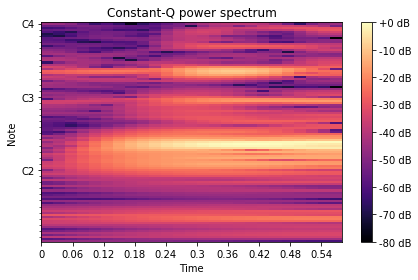

In [9]:
# specshow(librosa.amplitude_to_db(C, ref=np.max), 
#          sr=sr, 
#          bins_per_octave=bins_per_octave,  
#          x_axis='time', 
#          y_axis='cqt_note')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Constant-Q power spectrum')
# plt.tight_layout()

In [ ]:
print(C)  # you see this is just a 2D array

In [ ]:
# plt.figure(figsize=(10,10))
# plt.imshow(C)
# plt.show()

In [ ]:
# plt.figure(figsize=(10,10))
# plt.imshow(C[10:,10:])
# plt.show()

In [27]:
# basically this means `import note_evaluation_helper`
%run 'note_evaluation_helper.ipynb'

[]


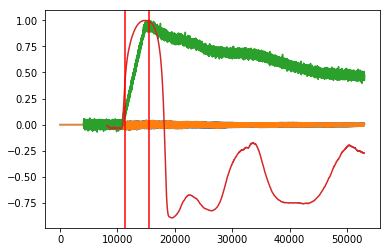

11664


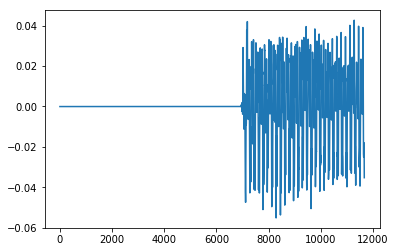

In [38]:
import matplotlib.pyplot as plt
import librosa
from librosa.display import specshow
import numpy as np
import soundfile as sf

bins_per_octave = 36
n_bins = 108
fmin = librosa.core.note_to_hz("B3")
y, sr = sf.read("soundfile_template/C4_60_x_x_x.wav")
plt.plot(y)

signal_short, signal_to_map = detect_onset_given_entire_signal(y[:,0])


signal_to_map = signal_to_map[-108*108:]
print(len(signal_to_map))
assert len(signal_to_map) == 108*108
plt.plot(signal_to_map)
plt.show()

In [40]:
C = librosa.magphase(librosa.cqt(signal_to_map,  
                                 # entry number 42288 is the end point
                                 # the onset is detected 4096 points before the point 42288
                                 # make sure it make sense
                                 sr=sr,
                                 hop_length = 2**7,
                                 bins_per_octave=bins_per_octave, 
                                 fmin=fmin,
                                 n_bins=n_bins))[0]
print(np.shape(C))

(108, 92)


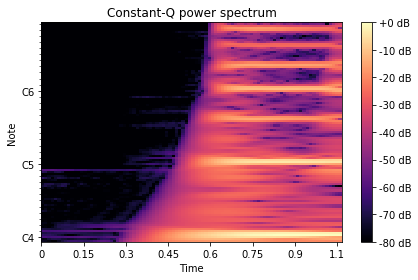

In [41]:
specshow(librosa.amplitude_to_db(C, ref=np.max), 
         sr=sr, 
         bins_per_octave=bins_per_octave,
         x_axis='time',
         y_axis='cqt_note',
         fmin=fmin)
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()

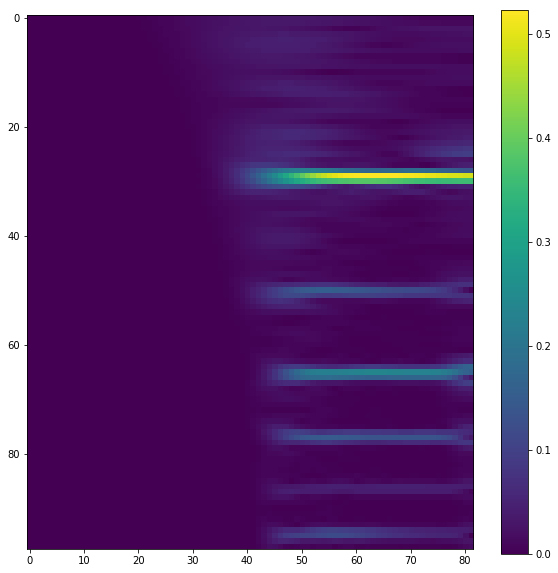

In [42]:
plt.figure(figsize=(10,10))
plt.imshow(C[10:,10:])
plt.colorbar()
plt.show()